In [1]:
import torch
import torch.nn as nn
import argparse
import os
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from kymatio.torch import Scattering2D
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import *
import warnings
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
from matplotlib import pyplot as plt

In [2]:
NUM_CLASS = 10
NUM_UNTARGET_CLASS = 3
EPOCHS = 5
REPLACE_LST = [7,8,9]

In [3]:
class UnLabel_Dataset(Dataset):
    def __init__(self, imgs, ground_truth, transform):
        self.imgs = imgs
        self.ground_truth = ground_truth
        self.transform = transform
    def __len__(self):
        return len(self.ground_truth)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        tar = self.ground_truth[idx]
        if self.transform:
            img = self.transform(img)
        #print(img.shape,tar.shape)
        return img[None:], tar

In [4]:
class get_img():
    def __init__(self, classes=[]):
        self.classes = classes
    def __call__(self, dataset):
        tensor_targets = torch.tensor(dataset.targets)
        semasks = torch.any(torch.stack( [torch.eq(tensor_targets, aelem).logical_or_(torch.eq(tensor_targets, aelem)) for aelem in self.classes], dim=0), dim = 0)
        imgs = dataset.data[semasks]
        tars = torch.tensor(dataset.targets)[semasks.tolist()].tolist()
        return imgs, tars

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

train_transforms = [transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(32, 4),
                    transforms.ToTensor(),
                    normalize,
                   ]
train_set = datasets.CIFAR10(root="./data", train=True,
                                     transform=transforms.Compose(train_transforms),
                                     download=True)
test_set = datasets.CIFAR10(root="./data", train=False,
                                    transform=transforms.Compose(
                                        [transforms.ToTensor(), normalize]
                                    ))

Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=512,
                                           shuffle=True,
                                           num_workers=6, 
                                           drop_last=False)
test_loader = torch.utils.data.DataLoader(test_set, 
                                           batch_size=1024,
                                           shuffle=False,
                                           num_workers=6, 
                                           drop_last=False)

In [7]:
get_imgs = get_img(REPLACE_LST)
unlabel_training_imgs, ground_truth_training = get_imgs(train_set)
unlabel_training_dataset = UnLabel_Dataset(unlabel_training_imgs,
                                           ground_truth_training,
                                           transform=transforms.Compose([transforms.ToTensor(), normalize])
                                          )
unlabel_training_dataloader = torch.utils.data.DataLoader(unlabel_training_dataset,
                                                          batch_size=512,
                                                          shuffle=False,
                                                          num_workers=6,
                                                          drop_last=False)

get_imgs = get_img(REPLACE_LST)
unlabel_test_imgs, ground_truth_test = get_imgs(test_set)
unlabel_test_dataset = UnLabel_Dataset(unlabel_test_imgs,
                                       ground_truth_test,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize])
                                      )
unlabel_test_dataloader = torch.utils.data.DataLoader(unlabel_test_dataset,
                                                          batch_size=512,
                                                          shuffle=False,
                                                          num_workers=6,
                                                          drop_last=False)


In [8]:
class replace_label():
    def __init__(self, labels=[], tar_label=7):
        super(replace_label, self).__init__()
        if len(labels)!=NUM_UNTARGET_CLASS:
            warnings.warn('Length of labels neq to NUM_UNTARGET_CLASS!')
        self.labels = labels
        self.tar_label = tar_label
    def __call__(self, labels):
        labels_cpy = torch.clone(labels)
        semasks = torch.any(torch.stack( [torch.eq(labels, aelem).logical_or_(torch.eq(labels, aelem)) for aelem in self.labels], dim=0), dim = 0)
        labels_cpy[semasks] = self.tar_label
        return labels_cpy

In [9]:
class ScatterCNN(nn.Module):
    def __init__(self, classes=10, **kwargs):
        super(ScatterCNN, self).__init__()
        self.norm0 = nn.BatchNorm2d(3*81)
        self.Conv0 = nn.Conv2d(3*81, 256, kernel_size=1, stride=1)
        self.norm1 = nn.BatchNorm2d(256)
        self.prelu1 = nn.PReLU()
        self.Conv1 = nn.Conv2d(256, 128, kernel_size=3, stride=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.Conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.prelu2 = nn.PReLU()
        self.fc = nn.Linear(64*1, classes)
    def feature(self, x):
        x = x.view(-1, 3 * 81, 8, 8)
        x = self.norm0(x)
        x = self.Conv0(x)
        x = self.norm1(x)
        x = self.prelu1(x)
        x = self.Conv1(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.Conv2(x)
        x = self.norm3(x)
        x = self.prelu2(x)
        x = x.reshape(x.size(0), -1)
        return x
    
    def forward(self, x):
        x = self.feature(x)
        x = self.fc(x)
        return x

In [10]:
model = ScatterCNN(classes=NUM_CLASS-NUM_UNTARGET_CLASS+1)

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                                    momentum=0.9,
                                    nesterov=False)
scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)

In [12]:
replace = replace_label(REPLACE_LST, NUM_CLASS-NUM_UNTARGET_CLASS)
Scattering2D = Scattering2D(J=2, shape=(32, 32)).cuda()
def train(model, train_loader, optimizer):
    model = model.to(device)
    model.train()
    num_examples = 0
    correct = 0
    train_loss = 0
    for data, target in tqdm(train_loader):
        target = replace(target)
        data, target = data.to(device), target.to(device)
        #print(target.shape, target)
        output = model(Scattering2D(data))
        #print(data.shape,output.shape, target.shape)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += F.cross_entropy(output, target, reduction='sum').item()
        num_examples += len(data)

    train_loss /= num_examples
    train_acc = 100. * correct / num_examples
    print(f'Train set: Average loss: {train_loss:.4f}, '
          f'Accuracy: {correct}/{num_examples} ({train_acc:.2f}%)')
    return train_loss, train_acc

In [13]:
def test(model, test_loader):
    device = next(model.parameters()).device
    
    model.eval()
    num_examples = 0
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            target = replace(target)
            data, target = data.to(device), target.to(device)
            output = model(Scattering2D(data))
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            num_examples += len(data)

    test_loss /= num_examples
    test_acc = 100. * correct / num_examples

    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{num_examples} ({test_acc:.2f}%)')

    return test_loss, test_acc

In [14]:
train_loss_lst=[]
train_acc_lst=[]
val_loss_lst=[]
val_acc_lst=[]
for epoch in range(0, EPOCHS):
    print(f"\nEpoch: {epoch}")
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(test_loss)
    val_acc_lst.append(test_acc)
    scheduler.step()


Epoch: 0


  0%|          | 0/98 [00:00<?, ?it/s]/home/deponce/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 98/98 [00:18<00:00,  5.34it/s]


Train set: Average loss: 1.1344, Accuracy: 29205/50000 (58.41%)


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Test set: Average loss: 1.0376, Accuracy: 6445/10000 (64.45%)

Epoch: 1


100%|██████████| 98/98 [00:18<00:00,  5.36it/s]


Train set: Average loss: 0.8456, Accuracy: 34768/50000 (69.54%)


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Test set: Average loss: 0.8098, Accuracy: 7099/10000 (70.99%)

Epoch: 2


100%|██████████| 98/98 [00:18<00:00,  5.34it/s]


Train set: Average loss: 0.7430, Accuracy: 36744/50000 (73.49%)


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Test set: Average loss: 0.7064, Accuracy: 7524/10000 (75.24%)

Epoch: 3


100%|██████████| 98/98 [00:18<00:00,  5.35it/s]


Train set: Average loss: 0.6841, Accuracy: 37822/50000 (75.64%)


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Test set: Average loss: 0.6715, Accuracy: 7676/10000 (76.76%)

Epoch: 4


100%|██████████| 98/98 [00:18<00:00,  5.36it/s]


Train set: Average loss: 0.6331, Accuracy: 38756/50000 (77.51%)


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

Test set: Average loss: 0.6150, Accuracy: 7859/10000 (78.59%)


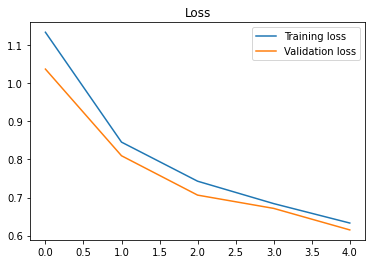

In [15]:
plt.plot(train_loss_lst, label='Training loss')
plt.plot(val_loss_lst, label='Validation loss')
plt.title('Loss')
plt.legend()

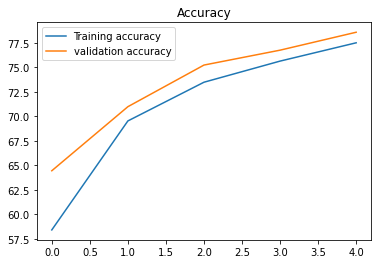

In [16]:
plt.plot(train_acc_lst, label='Training accuracy')
plt.plot(val_acc_lst, label='validation accuracy')
plt.title('Accuracy')
plt.legend()

In [23]:
model.eval()
unlabel_features_training = torch.empty((0,64))
grand_truth_training = torch.empty((0))
for data, target in tqdm(unlabel_training_dataloader):
    target = replace(target)
    data, target = data.to(device), target
    feature = model.feature((Scattering2D(data)))
    unlabel_features_training = torch.cat((unlabel_features_training,feature.detach().cpu()), 0)
    grand_truth_training = torch.cat((grand_truth_training, target), 0)
unlabel_features_training = unlabel_features_training.numpy()
grand_truth_training = grand_truth_training.numpy()
print(unlabel_features_training.shape)
print(grand_truth_training.shape)

100%|██████████| 30/30 [00:04<00:00,  6.54it/s]

(15000, 64)
(15000,)


In [24]:
model.eval()
unlabel_features_test = torch.empty((0,64))
grand_truth_test = torch.empty((0))
for data, target in tqdm(unlabel_test_dataloader):
    target = replace(target)
    data, target = data.to(device), target
    feature = model.feature((Scattering2D(data)))
    unlabel_features_test = torch.cat((unlabel_features_test,feature.detach().cpu()), 0)
    grand_truth_test = torch.cat((grand_truth_test, target), 0)
unlabel_features_test = unlabel_features_test.numpy()
grand_truth_test = grand_truth_test.numpy()
print(unlabel_features_test.shape)
print(grand_truth_test.shape)

100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

(3000, 64)
(3000,)


In [25]:
GMM = GaussianMixture(n_components=NUM_UNTARGET_CLASS).fit(unlabel_features_training)